In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [3]:
input_dir = '../input'
df = pd.read_csv('{}/bitcoin_price.csv'.format(input_dir), parse_dates=['Date'], index_col=0)
df['Adj Close'] = df.Close
df.drop(['Close', 'Volume', 'Market Cap'], 1, inplace=True)
df.head()

,Open,High,Low,Adj Close
Date,,,,
2017-09-05,4228.29,4427.84,3998.11,4376.53
2017-09-04,4591.63,4591.63,4108.40,4236.31
2017-09-03,4585.27,4714.08,4417.59,4582.96
2017-09-02,4901.42,4975.04,4469.24,4578.77
2017-09-01,4701.76,4892.01,4678.53,4892.01


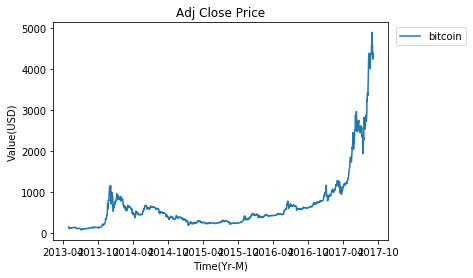

In [4]:
plt.plot(df['Adj Close'], label='bitcoin')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlabel('Time(Yr-M)')
plt.ylabel('Value(USD)')
plt.title('Adj Close Price')
plt.show()

In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,Open,High,Low,Adj Close
Date,,,,
2017-09-05,0.860720,0.888337,0.852499,0.893133
2017-09-04,0.935900,0.921761,0.876408,0.864064
2017-09-03,0.934584,0.946748,0.943434,0.935929
2017-09-02,1.000000,1.000000,0.954630,0.935061
2017-09-01,0.958688,0.983057,1.000000,1.000000


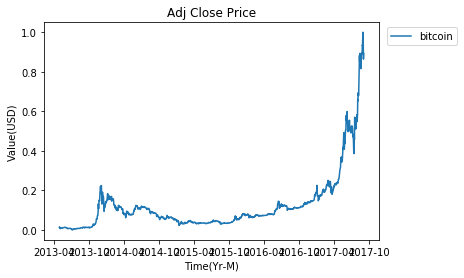

In [6]:
plt.plot(df['Adj Close'], label='bitcoin')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlabel('Time(Yr-M)')
plt.ylabel('Value(USD)')
plt.title('Adj Close Price')
plt.show()

In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [9]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train.shape, y_train.shape)
# print (y_train[0])

(1412, 22, 4) (1412,)


In [28]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [30]:
model = build_model([4,window,1])

Compilation Time :  0.03242611885070801


In [31]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1270 samples, validate on 142 samples
Epoch 1/90
1270/1270 [==============================] - 4s 3ms/step - loss: 0.0307 - acc: 0.0000e+00 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 2/90
1270/1270 [==============================] - 2s 2ms/step - loss: 0.0183 - acc: 0.0000e+00 - val_loss: 0.0184 - val_acc: 0.0000e+00
Epoch 3/90
1270/1270 [==============================] - 2s 2ms/step - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 4/90
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 5/90
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0026 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 6/90
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0027 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 7/90
1270/1270 [==============================] - 3s 2ms/step - loss: 0.0011 - acc: 0.0000e+00 

KeyboardInterrupt: 